# 现代循环神经网络

前一章中我们介绍了循环神经网络的基础知识，
这种网络可以更好地处理序列数据。
我们在文本数据上实现了基于循环神经网络的语言模型，
但是对于当今各种各样的序列学习问题，这些技术可能并不够用。

例如，循环神经网络在实践中一个常见问题是数值不稳定性。
尽管我们已经应用了梯度裁剪等技巧来缓解这个问题，
但是仍需要通过设计更复杂的序列模型来进一步处理它。
具体来说，我们将引入两个广泛使用的网络，
即*门控循环单元*（gated recurrent units，GRU）和
*长短期记忆网络*（long short-term memory，LSTM）。
然后，我们将基于一个单向隐藏层来扩展循环神经网络架构。
我们将描述具有多个隐藏层的深层架构，
并讨论基于前向和后向循环计算的双向设计。
现代循环网络经常采用这种扩展。
在解释这些循环神经网络的变体时，
我们将继续考虑建模问题。

事实上，语言建模只揭示了序列学习能力的冰山一角。
在各种序列学习问题中，如自动语音识别、文本到语音转换和机器翻译，
输入和输出都是任意长度的序列。
为了阐述如何拟合这种类型的数据，
我们将以机器翻译为例介绍基于循环神经网络的
“编码器－解码器”架构和束搜索，并用它们来生成序列。



# 门控循环单元（GRU）


之前我们讨论了如何在循环神经网络中计算梯度，
以及矩阵连续乘积可以导致梯度消失或梯度爆炸的问题。
下面我们简单思考一下这种梯度异常在实践中的意义：

* 我们可能会遇到这样的情况：早期观测值对预测所有未来观测值具有非常重要的意义。
  考虑一个极端情况，其中第一个观测值包含一个校验和，
  目标是在序列的末尾辨别校验和是否正确。
  在这种情况下，第一个词元的影响至关重要。
  我们希望有某些机制能够在一个记忆元里存储重要的早期信息。
  如果没有这样的机制，我们将不得不给这个观测值指定一个非常大的梯度，
  因为它会影响所有后续的观测值。
* 我们可能会遇到这样的情况：一些词元没有相关的观测值。
  例如，在对网页内容进行情感分析时，
  可能有一些辅助HTML代码与网页传达的情绪无关。
  我们希望有一些机制来*跳过*隐状态表示中的此类词元。
* 我们可能会遇到这样的情况：序列的各个部分之间存在逻辑中断。
  例如，书的章节之间可能会有过渡存在，
  或者证券的熊市和牛市之间可能会有过渡存在。
  在这种情况下，最好有一种方法来*重置*我们的内部状态表示。

在学术界已经提出了许多方法来解决这类问题。
其中最早的方法是"长短期记忆"（long-short-term memory，LSTM）
`Hochreiter.Schmidhuber.1997`，
门控循环单元（gated recurrent unit，GRU）
`Cho.Van-Merrienboer.Bahdanau.ea.2014`
是一个稍微简化的变体，通常能够提供同等的效果，
并且计算`Chung.Gulcehre.Cho.ea.2014`的速度明显更快。
由于门控循环单元更简单，我们从它开始解读。

## 门控隐状态

门控循环单元与普通的循环神经网络之间的关键区别在于：
前者支持隐状态的门控。
这意味着模型有专门的机制来确定应该何时更新隐状态，
以及应该何时重置隐状态。
这些机制是可学习的，并且能够解决了上面列出的问题。
例如，如果第一个词元非常重要，
模型将学会在第一次观测之后不更新隐状态。
同样，模型也可以学会跳过不相关的临时观测。
最后，模型还将学会在需要的时候重置隐状态。
下面我们将详细讨论各类门控。

### 重置门和更新门

我们首先介绍*重置门*（reset gate）和*更新门*（update gate）。
我们把它们设计成$(0, 1)$区间中的向量，
这样我们就可以进行凸组合。
重置门允许我们控制“可能还想记住”的过去状态的数量；
更新门将允许我们控制新状态中有多少个是旧状态的副本。

我们从构造这些门控开始。
描述了门控循环单元中的重置门和更新门的输入，
输入是由当前时间步的输入和前一时间步的隐状态给出。
两个门的输出是由使用sigmoid激活函数的两个全连接层给出。

![在门控循环单元模型中计算重置门和更新门](https://zh.d2l.ai/_images/gru-1.svg)


我们来看一下门控循环单元的数学表达。
对于给定的时间步$t$，假设输入是一个小批量
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$
（样本个数$n$，输入个数$d$），
上一个时间步的隐状态是
$\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$
（隐藏单元个数$h$）。
那么，重置门$\mathbf{R}_t \in \mathbb{R}^{n \times h}$和
更新门$\mathbf{Z}_t \in \mathbb{R}^{n \times h}$的计算如下所示：

$$
\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{aligned}
$$

其中$\mathbf{W}_{xr}, \mathbf{W}_{xz} \in \mathbb{R}^{d \times h}$
和$\mathbf{W}_{hr}, \mathbf{W}_{hz} \in \mathbb{R}^{h \times h}$是权重参数，
$\mathbf{b}_r, \mathbf{b}_z \in \mathbb{R}^{1 \times h}$是偏置参数。
请注意，在求和过程中会触发广播机制。
我们使用sigmoid函数将输入值转换到区间$(0, 1)$。

### 候选隐状态

接下来，让我们将重置门$\mathbf{R}_t$
中的常规隐状态更新机制集成，
得到在时间步$t$的*候选隐状态*（candidate hidden state）
$\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$。

$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h),$$

其中$\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$
和$\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$是权重参数，
$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$是偏置项，
符号$\odot$是Hadamard积（按元素乘积）运算符。
在这里，我们使用tanh非线性激活函数来确保候选隐状态中的值保持在区间$(-1, 1)$中。

$\mathbf{R}_t$和$\mathbf{H}_{t-1}$
的元素相乘可以减少以往状态的影响。
每当重置门$\mathbf{R}_t$中的项接近$1$时，
我们恢复一个普通的循环神经网络。
对于重置门$\mathbf{R}_t$中所有接近$0$的项，
候选隐状态是以$\mathbf{X}_t$作为输入的多层感知机的结果。
因此，任何预先存在的隐状态都会被*重置*为默认值。


![在门控循环单元模型中计算候选隐状态](https://zh.d2l.ai/_images/gru-2.svg)

### 隐状态

上述的计算结果只是候选隐状态，我们仍然需要结合更新门$\mathbf{Z}_t$的效果。
这一步确定新的隐状态$\mathbf{H}_t \in \mathbb{R}^{n \times h}$
在多大程度上来自旧的状态$\mathbf{H}_{t-1}$和
新的候选状态$\tilde{\mathbf{H}}_t$。
更新门$\mathbf{Z}_t$仅需要在
$\mathbf{H}_{t-1}$和$\tilde{\mathbf{H}}_t$
之间进行按元素的凸组合就可以实现这个目标。
这就得出了门控循环单元的最终更新公式：

$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.$$

每当更新门$\mathbf{Z}_t$接近$1$时，模型就倾向只保留旧状态。
此时，来自$\mathbf{X}_t$的信息基本上被忽略，
从而有效地跳过了依赖链条中的时间步$t$。
相反，当$\mathbf{Z}_t$接近$0$时，
新的隐状态$\mathbf{H}_t$就会接近候选隐状态$\tilde{\mathbf{H}}_t$。
这些设计可以帮助我们处理循环神经网络中的梯度消失问题，
并更好地捕获时间步距离很长的序列的依赖关系。
例如，如果整个子序列的所有时间步的更新门都接近于$1$，
则无论序列的长度如何，在序列起始时间步的旧隐状态都将很容易保留并传递到序列结束。


![计算门控循环单元模型中的隐状态](https://zh.d2l.ai/_images/gru-3.svg)

总之，门控循环单元具有以下两个显著特征：

* 重置门有助于捕获序列中的短期依赖关系；
* 更新门有助于捕获序列中的长期依赖关系。

## 从零开始实现

为了更好地理解门控循环单元模型，我们从零开始实现它。
首先，我们读取时间机器数据集：


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### [**初始化模型参数**]

下一步是初始化模型参数。
我们从标准差为$0.01$的高斯分布中提取权重，
并将偏置项设为$0$，超参数`num_hiddens`定义隐藏单元的数量，
实例化与更新门、重置门、候选隐状态和输出层相关的所有权重和偏置。


In [2]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 定义模型

现在我们将[**定义隐状态的初始化函数**]`init_gru_state`。
此函数返回一个形状为（批量大小，隐藏单元个数）的张量，张量的值全部为零。


In [3]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

现在我们准备[**定义门控循环单元模型**]，
模型的架构与基本的循环神经网络单元是相同的，
只是权重更新公式更为复杂。


In [4]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

### [**训练**]与预测
训练结束后，我们分别打印输出训练集的困惑度，
以及前缀“time traveler”和“traveler”的预测序列上的困惑度。


perplexity 1.1, 34054.8 tokens/sec on cuda:0
time travellerit s against reason said filby but you willnever c
traveller after the pauserequired for the proper assimilati


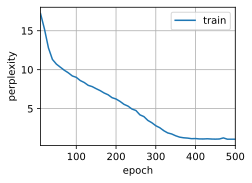

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## [**简洁实现**]

高级API包含了前文介绍的所有配置细节，
所以我们可以直接实例化门控循环单元模型。
这段代码的运行速度要快得多，
因为它使用的是编译好的运算符而不是Python来处理之前阐述的许多细节。


perplexity 1.0, 323446.8 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


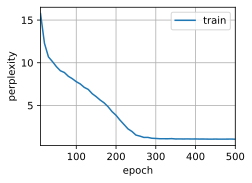

In [6]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 小结

- 门控循环神经网络可以更好地捕获时间步距离很长的序列上的依赖关系。
- 重置门有助于捕获序列中的短期依赖关系。
- 更新门有助于捕获序列中的长期依赖关系。
- 重置门打开时，门控循环单元包含基本循环神经网络；更新门打开时，门控循环单元可以跳过子序列。

# 长短期记忆网络（LSTM）

长期以来，隐变量模型存在着长期信息保存和短期输入缺失的问题。
解决这一问题的最早方法之一是长短期存储器（long short-term memory，LSTM）
`Hochreiter.Schmidhuber.1997`。
它有许多与门控循环单元一样的属性。
有趣的是，长短期记忆网络的设计比门控循环单元稍微复杂一些，
却比门控循环单元早诞生了近20年。

## 门控记忆元

可以说，长短期记忆网络的设计灵感来自于计算机的逻辑门。
长短期记忆网络引入了*记忆元*（memory cell），或简称为*单元*（cell）。
有些文献认为记忆元是隐状态的一种特殊类型，
它们与隐状态具有相同的形状，其设计目的是用于记录附加的信息。
为了控制记忆元，我们需要许多门。
其中一个门用来从单元中输出条目，我们将其称为*输出门*（output gate）。
另外一个门用来决定何时将数据读入单元，我们将其称为*输入门*（input gate）。
我们还需要一种机制来重置单元的内容，由*遗忘门*（forget gate）来管理，
这种设计的动机与门控循环单元相同，
能够通过专用机制决定什么时候记忆或忽略隐状态中的输入。
让我们看看这在实践中是如何运作的。

### 输入门、忘记门和输出门

就如在门控循环单元中一样，
当前时间步的输入和前一个时间步的隐状态
作为数据送入长短期记忆网络的门中，
如下所示。
它们由三个具有sigmoid激活函数的全连接层处理，
以计算输入门、遗忘门和输出门的值。
因此，这三个门的值都在$(0, 1)$的范围内。

![长短期记忆模型中的输入门、遗忘门和输出门](https://zh.d2l.ai/_images/lstm-0.svg)

我们来细化一下长短期记忆网络的数学表达。
假设有$h$个隐藏单元，批量大小为$n$，输入数为$d$。
因此，输入为$\mathbf{X}_t \in \mathbb{R}^{n \times d}$，
前一时间步的隐状态为$\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$。
相应地，时间步$t$的门被定义如下：
输入门是$\mathbf{I}_t \in \mathbb{R}^{n \times h}$，
遗忘门是$\mathbf{F}_t \in \mathbb{R}^{n \times h}$，
输出门是$\mathbf{O}_t \in \mathbb{R}^{n \times h}$。
它们的计算方法如下：

$$
\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{aligned}
$$

其中$\mathbf{W}_{xi}, \mathbf{W}_{xf}, \mathbf{W}_{xo} \in \mathbb{R}^{d \times h}$
和$\mathbf{W}_{hi}, \mathbf{W}_{hf}, \mathbf{W}_{ho} \in \mathbb{R}^{h \times h}$是权重参数，
$\mathbf{b}_i, \mathbf{b}_f, \mathbf{b}_o \in \mathbb{R}^{1 \times h}$是偏置参数。

### 候选记忆元

由于还没有指定各种门的操作，所以先介绍*候选记忆元*（candidate memory cell）
$\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$。
它的计算与上面描述的三个门的计算类似，
但是使用$\tanh$函数作为激活函数，函数的值范围为$(-1, 1)$。
下面导出在时间步$t$处的方程：

$$\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c),$$

其中$\mathbf{W}_{xc} \in \mathbb{R}^{d \times h}$和
$\mathbf{W}_{hc} \in \mathbb{R}^{h \times h}$是权重参数，
$\mathbf{b}_c \in \mathbb{R}^{1 \times h}$是偏置参数。



![长短期记忆模型中的候选记忆元](https://zh.d2l.ai/_images/lstm-1.svg)

### 记忆元

在门控循环单元中，有一种机制来控制输入和遗忘（或跳过）。
类似地，在长短期记忆网络中，也有两个门用于这样的目的：
输入门$\mathbf{I}_t$控制采用多少来自$\tilde{\mathbf{C}}_t$的新数据，
而遗忘门$\mathbf{F}_t$控制保留多少过去的
记忆元$\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$的内容。
使用按元素乘法，得出：

$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$

如果遗忘门始终为$1$且输入门始终为$0$，
则过去的记忆元$\mathbf{C}_{t-1}$
将随时间被保存并传递到当前时间步。
引入这种设计是为了缓解梯度消失问题，
并更好地捕获序列中的长距离依赖关系。

这样我们就得到了计算记忆元的流程图。

![在长短期记忆网络模型中计算记忆元](https://zh.d2l.ai/_images/lstm-2.svg)


### 隐状态

最后，我们需要定义如何计算隐状态
$\mathbf{H}_t \in \mathbb{R}^{n \times h}$，
这就是输出门发挥作用的地方。
在长短期记忆网络中，它仅仅是记忆元的$\tanh$的门控版本。
这就确保了$\mathbf{H}_t$的值始终在区间$(-1, 1)$内：

$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$

只要输出门接近$1$，我们就能够有效地将所有记忆信息传递给预测部分，
而对于输出门接近$0$，我们只保留记忆元内的所有信息，而不需要更新隐状态。



![在长短期记忆模型中计算隐状态](https://zh.d2l.ai/_images/lstm-3.svg)


## 从零开始实现

现在，我们从零开始实现长短期记忆网络。
我们首先加载时光机器数据集。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### 初始化模型参数

接下来，我们需要定义和初始化模型参数。
如前所述，超参数定义隐藏单元的数量。
我们按照标准差$0.01$的高斯分布初始化权重，并将偏置项设为$0$。


In [2]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆元参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 定义模型

在[**初始化函数**]中，
长短期记忆网络的隐状态需要返回一个*额外*的记忆元，
单元的值为0，形状为（批量大小，隐藏单元数）。
因此，我们得到以下的状态初始化。


In [3]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

[**实际模型**]的定义与我们前面讨论的一样：
提供三个门和一个额外的记忆元。
请注意，只有隐状态才会传递到输出层，
而记忆元$\mathbf{C}_t$不直接参与输出计算。


In [4]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

### [**训练**]和预测

perplexity 1.1, 38932.7 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller a centery bet move aroul my concevar so it said t


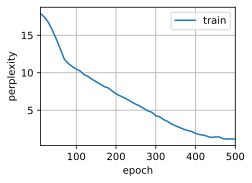

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## [**简洁实现**]

使用高级API，我们可以直接实例化`LSTM`模型。
高级API封装了前文介绍的所有配置细节。
这段代码的运行速度要快得多，
因为它使用的是编译好的运算符而不是Python来处理之前阐述的许多细节。


perplexity 1.1, 329594.0 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofchee foundea tare as an


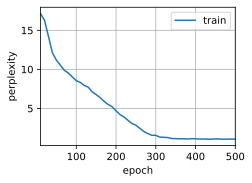

In [6]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

长短期记忆网络是典型的具有重要状态控制的隐变量自回归模型。
多年来已经提出了其许多变体，例如，多层、残差连接、不同类型的正则化。
然而，由于序列的长距离依赖性，训练长短期记忆网络
和其他序列模型（例如门控循环单元）的成本是相当高的。
在后面的内容中，我们将讲述更高级的替代模型，如Transformer。

## 小结

- 长短期记忆网络有三种类型的门：输入门、遗忘门和输出门。
- 长短期记忆网络的隐藏层输出包括“隐状态”和“记忆元”。只有隐状态会传递到输出层，而记忆元完全属于内部信息。
- 长短期记忆网络可以缓解梯度消失和梯度爆炸。


# 深度循环神经网络


到目前为止，我们只讨论了具有一个单向隐藏层的循环神经网络。
其中，隐变量和观测值与具体的函数形式的交互方式是相当随意的。
只要交互类型建模具有足够的灵活性，这就不是一个大问题。
然而，对一个单层来说，这可能具有相当的挑战性。
之前在线性模型中，我们通过添加更多的层来解决这个问题。
而在循环神经网络中，我们首先需要确定如何添加更多的层，
以及在哪里添加额外的非线性，因此这个问题有点棘手。

事实上，我们可以将多层循环神经网络堆叠在一起，
通过对几个简单层的组合，产生了一个灵活的机制。
特别是，数据可能与不同层的堆叠有关。
例如，我们可能希望保持有关金融市场状况
（熊市或牛市）的宏观数据可用，
而微观数据只记录较短期的时间动态。

下图描述了一个具有$L$个隐藏层的深度循环神经网络，
每个隐状态都连续地传递到当前层的下一个时间步和下一层的当前时间步。

![深度循环神经网络结构](https://zh.d2l.ai/_images/deep-rnn.svg)


## 函数依赖关系

我们可以将深度架构中的函数依赖关系形式化，
这个架构是由$L$个隐藏层构成。
后续的讨论主要集中在经典的循环神经网络模型上，
但是这些讨论也适应于其他序列模型。

假设在时间步$t$有一个小批量的输入数据
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$
（样本数：$n$，每个样本中的输入数：$d$）。
同时，将$l^\mathrm{th}$隐藏层（$l=1,\ldots,L$）
的隐状态设为$\mathbf{H}_t^{(l)}  \in \mathbb{R}^{n \times h}$
（隐藏单元数：$h$），
输出层变量设为$\mathbf{O}_t \in \mathbb{R}^{n \times q}$
（输出数：$q$）。
设置$\mathbf{H}_t^{(0)} = \mathbf{X}_t$，
第$l$个隐藏层的隐状态使用激活函数$\phi_l$，则：

$$\mathbf{H}_t^{(l)} = \phi_l(\mathbf{H}_t^{(l-1)} \mathbf{W}_{xh}^{(l)} + \mathbf{H}_{t-1}^{(l)} \mathbf{W}_{hh}^{(l)}  + \mathbf{b}_h^{(l)}),$$


其中，权重$\mathbf{W}_{xh}^{(l)} \in \mathbb{R}^{h \times h}$，
$\mathbf{W}_{hh}^{(l)} \in \mathbb{R}^{h \times h}$和
偏置$\mathbf{b}_h^{(l)} \in \mathbb{R}^{1 \times h}$
都是第$l$个隐藏层的模型参数。

最后，输出层的计算仅基于第$l$个隐藏层最终的隐状态：

$$\mathbf{O}_t = \mathbf{H}_t^{(L)} \mathbf{W}_{hq} + \mathbf{b}_q,$$

其中，权重$\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$和偏置$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$都是输出层的模型参数。

与多层感知机一样，隐藏层数目$L$和隐藏单元数目$h$都是超参数。
也就是说，它们可以由我们调整的。
另外，用门控循环单元或长短期记忆网络的隐状态
来代替隐状态进行计算，
可以很容易地得到深度门控循环神经网络或深度长短期记忆神经网络。

## 简洁实现

实现多层循环神经网络所需的许多逻辑细节在高级API中都是现成的。
简单起见，我们仅示范使用此类内置函数的实现方式。
以长短期记忆网络模型为例，
实际上唯一的区别是我们指定了层的数量，
而不是使用单一层这个默认值。
像往常一样，我们从加载数据集开始。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

像选择超参数这类架构决策也跟之前的决策非常相似。
因为我们有不同的词元，所以输入和输出都选择相同数量，即`vocab_size`。
隐藏单元的数量仍然是$256$。
唯一的区别是，我们现在(**通过`num_layers`的值来设定隐藏层数**)。


In [2]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)

## 训练与预测

由于使用了长短期记忆网络模型来实例化两个层，因此训练速度被大大降低了。


perplexity 1.0, 170291.6 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


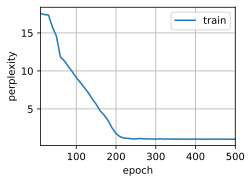

In [5]:
num_epochs, lr = 500, 2
d2l.train_ch8(model, train_iter, vocab, lr*1.0, num_epochs, device)

## 小结

- 在深度循环神经网络中，隐状态的信息被传递到当前层的下一时间步和下一层的当前时间步。
- 有许多不同风格的深度循环神经网络，如长短期记忆网络、门控循环单元、或经典循环神经网络。这些模型在深度学习框架的高级API中都有涵盖。
- 总体而言，深度循环神经网络需要大量的调参（如学习率和修剪）来确保合适的收敛，模型的初始化也需要谨慎。